In [ ]:

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install EoN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for EoN: filename=EoN-1.2-py3-none-any.whl size=122468 sha256=95d76f6d8e4f7ce59ec889f0da807323d67cdb473104492d57059002fca63c48
  Stored in directory: /root/.cache/pip/wheels/10/ec/88/6daefcc5ebdf7e373db9da6a61386f33143571d885c4c7708a
Successfully built EoN


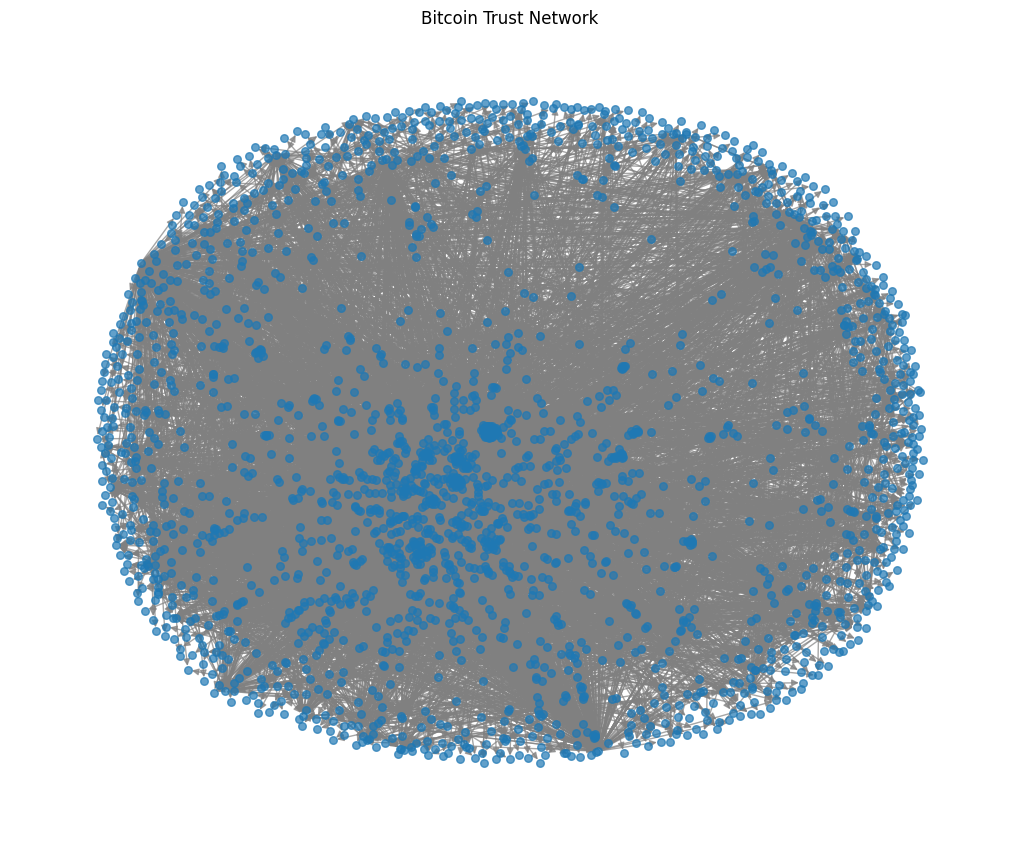

Average Transmission Rate (tau): 0.5085
Average Recovery Rate (gamma): 0.4915


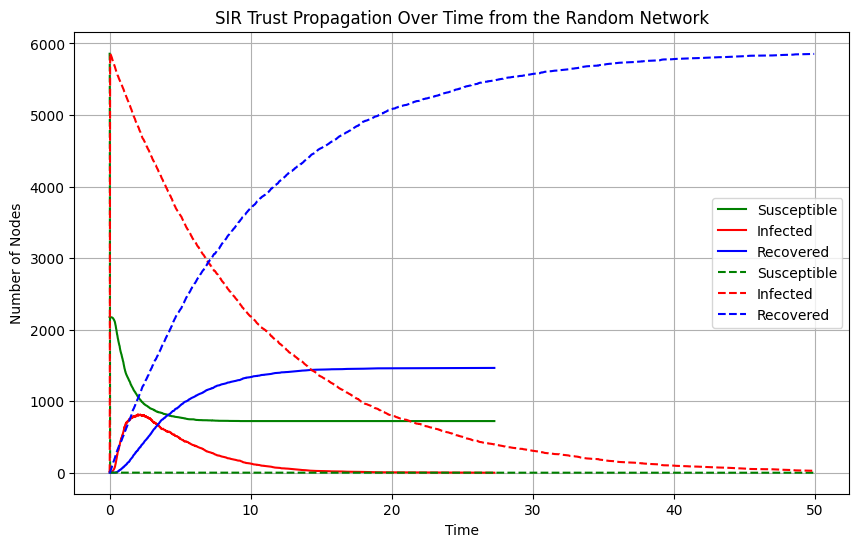

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import EoN
import pandas as pd

# -----------------------------------
# Load and Prepare the Dataset
# -----------------------------------
df = pd.read_csv('/content/drive/MyDrive/filtered_soc-sign-bitcoinotc.csv')
df = df.rename(columns={'RATING': 'weight'}) #the name of the column is changed from 'RATING' to 'weight'

print(df.head())


# Create a directed, weighted trust graph
G = nx.from_pandas_edgelist(df, source='SOURCE', target='TARGET', edge_attr='weight', create_using=nx.DiGraph())

# Visualize the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, with_labels=False, node_size=30, edge_color='gray', alpha=0.7)
plt.title("Bitcoin Trust Network")
plt.show()

# -----------------------------------
# Normalize and Compute Transmission & Recovery Rates
# -----------------------------------
min_rating = df["weight"].min() #minimum trust rating
max_rating = df["weight"].max() #maximum trust rating

# Normalize trust values to [0, 1]
df["transmission_rate"] = np.clip((df["weight"] - min_rating) / (max_rating - min_rating), 0, 1) #min max normalisation to find the transmission rates.
df["recovery_rate"] = 1 - df["transmission_rate"]

# Use average rates for global parameters
average_tau = df["transmission_rate"].mean() #constant transmission rate is given by the average of all transmission rates
average_gamma = df["recovery_rate"].mean()  #constant recovery rate is given by the average of all recovery rates

print(f"Average Transmission Rate (tau): {average_tau:.4f}")
print(f"Average Recovery Rate (gamma): {average_gamma:.4f}")

# -----------------------------------
# Run the SIR Simulation
# -----------------------------------
seed_nodes1 = random.sample(list(G.nodes()), 10) #selects random sample of 10 nodes from G to be the nodes that are infected at time = 0

# Run SIR model using EoN

sim= EoN.fast_SIR(
    G,
    tau=average_tau,
    gamma=average_gamma,
    initial_infecteds=seed_nodes1,
    return_full_data=True,
    tmax=100
)


t,S,I,R= EoN.fast_SIR(
    G,
    tau=average_tau,
    gamma=average_gamma,
    initial_infecteds=seed_nodes1,
    tmax=100
)

H=nx.gnp_random_graph(5881,p=0.5,directed=True)
seed_nodes2 = random.sample(list(H.nodes()), 10)

sim2= EoN.fast_SIR(
    H,
    tau=average_tau,
    gamma=average_gamma,
    initial_infecteds=seed_nodes2,
    return_full_data=True,
    tmax=50
)



t2,S2,I2,R2= EoN.fast_SIR(
    H,
    tau=0.1,
    gamma=0.1,
    initial_infecteds=seed_nodes2,
    tmax=50)

# Epidemic Curve which plots the number of nodes at each stage (susceptible, infected, recovered) since the beginning of time.
plt.figure(figsize=(10, 6))
plt.plot(t, S, label="Susceptible", color='green')
plt.plot(t, I, label="Infected", color='red')
plt.plot(t, R, label="Recovered", color='blue')
plt.xlabel("Time")
plt.ylabel("Number of Nodes")
plt.title("SIR Trust Propagation Over Time from the Real Bitcoin Net")
plt.legend()
plt.grid(True)



plt.plot(t2, S2, label="Susceptible",linestyle='dashed', color='green')
plt.plot(t2, I2, label="Infected",linestyle='dashed', color='red')
plt.plot(t2, R2, label="Recovered",linestyle='dashed', color='blue')
plt.xlabel("Time")
plt.ylabel("Number of Nodes")
plt.title("SIR Trust Propagation Over Time from the Random Network")
plt.legend()
plt.grid(True)
plt.show()

#The number of susceptible nodes only decreased until it hit a plateau at about 800 nodes.
#THe number of recovered nodes only increased with a plateau at 1300-1400
#The number of infected nodes increased to slightly over 750 and then decreased to 0 at the last time step.

